In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
random_state = 11

In [3]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [5]:
master = master.drop(columns = 'Unnamed: 0')

In [6]:
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


(array([3.051e+03, 4.200e+01, 1.100e+01, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.01415439, 0.02830879, 0.04246318, 0.05661757,
        0.07077196, 0.08492636, 0.09908075, 0.11323514, 0.12738953,
        0.14154393]),
 <a list of 10 Patch objects>)

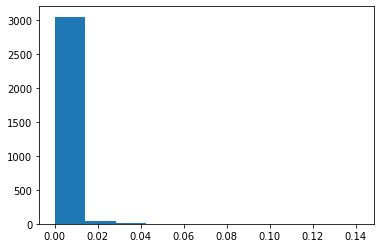

In [14]:
plt.hist(master['case_per_pop'])

In [10]:
master['case_per_pop'].describe()

count    3108.000000
mean        0.001994
std         0.004738
min         0.000000
25%         0.000333
50%         0.000784
75%         0.001943
max         0.141544
Name: case_per_pop, dtype: float64

In [36]:
master.shape[0] * .1

310.8

In [39]:
master.sort_values(by = 'case_per_pop', ascending = False).head(311)

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
2478,trousdale county,TN,47169,9573,9105,468,9105,8152,911,24,...,0.0,0.0,0.0,0.0,47,47169,25.0,0.141544,0.002612,0.018450
106,lincoln county,AR,5079,13695,13622,73,13622,9104,4292,49,...,0.0,0.0,0.0,0.0,5,5079,0.0,0.066229,0.000000,0.000000
1794,dakota county,NE,31043,20317,19820,497,19820,13995,954,592,...,0.0,0.0,0.0,0.0,31,31043,0.0,0.065118,0.000000,0.000000
1332,nobles county,MN,27105,21839,21450,389,21450,17274,1020,131,...,0.0,0.0,0.0,0.0,27,27105,48.0,0.053894,0.002198,0.040782
2397,bledsoe county,TN,47007,14602,14198,404,14198,13216,659,237,...,0.0,0.0,0.0,0.0,47,47007,25.0,0.041364,0.001712,0.041391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,terrebonne parish,LA,22109,112587,109905,2682,109905,79613,21588,6391,...,0.0,0.0,0.0,0.0,22,22109,567.0,0.004450,0.005036,1.131737
228,crowley county,CO,8025,5630,5382,248,5382,4978,206,85,...,0.0,0.0,0.0,0.0,8,8025,0.0,0.004440,0.000000,0.000000
1514,jefferson davis county,MS,28065,11495,11427,68,11427,4360,7036,0,...,0.0,0.0,0.0,0.0,28,28065,35.0,0.004437,0.003045,0.686275
55,randolph county,AL,1111,22574,22244,330,22244,17443,4547,51,...,0.0,0.0,0.0,0.0,1,1111,15.0,0.004430,0.000664,0.150000


In [ ]:
X = master.drop(columns = ['county_x', 'state', 'id', 'population'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split()